In [1]:
import ROOT
from ROOT import TMath
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os

Welcome to JupyROOT 6.26/02


In [20]:
#all data

'''Importing the data from the ROOT files'''

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")
ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")
WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")
data1 = ROOT.TFile.Open("data_A.GamGam.root")
data2 = ROOT.TFile.Open("data_B.GamGam.root")
data3 = ROOT.TFile.Open("data_C.GamGam.root")
data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels = {"ttH":ttH.Get("mini"),
            "ggH":ggH.Get("mini"),
            "WWH":WWH.Get("mini"), 
            'data1':data1.Get('mini'), 
            #'data2':data2.Get('mini'),   data2 broken for some reason?
            'data3':data3.Get('mini'),
            'data4':data4.Get('mini')
           }

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

# Here we shall store the two photons & outputs 
dataset = []
dataset2 = []

# Prepare Data for NN
# Events are not filtered by LLT or HLT

for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 50000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        dataset.append(data)
        dataset2.append(data2)
        counter += 1
        
        
random.shuffle(dataset)
dataset = np.asarray(dataset) #non-processed

random.shuffle(dataset2)
dataset2 = np.asarray(dataset2) #processed

Channel: ttH has 576491 entries
Channel: ggH has 1054711 entries
Channel: WWH has 497468 entries
Channel: data1 has 430344 entries
Channel: data3 has 2237187 entries
Channel: data4 has 3602176 entries
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data3
Processing Channel  data4


In [17]:
#only background file

data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels = {'data4':data4.Get('mini')}

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

back_dataset = []
back_dataset2 = []

for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        back_dataset.append(data)
        back_dataset2.append(data2)
        counter += 1
        
        
random.shuffle(back_dataset)
back_dataset = np.asarray(back_dataset) #non-processed

random.shuffle(back_dataset2)
back_dataset2 = np.asarray(back_dataset2) #processed

Channel: data4 has 3602176 entries
Processing Channel  data4


In [3]:
#signal and background files

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")
ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")
WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")
data1 = ROOT.TFile.Open("data_A.GamGam.root")
data3 = ROOT.TFile.Open("data_C.GamGam.root")
data4 = ROOT.TFile.Open("data_D.GamGam.root")

Channels2 = {"ttH":ttH.Get("mini"),
            "ggH":ggH.Get("mini"),
            "WWH":WWH.Get("mini"), 
            'data1':data1.Get('mini'), 
            'data3':data3.Get('mini'),
            'data4':data4.Get('mini')
           }

for channel in Channels2:
    print("Channel:",channel,"has",Channels2[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

signal_dataset = []
signal_dataset2 = []

for channel in Channels2:
    print("Processing Channel ",channel)
    Channel = Channels2[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        signal_dataset.append(data)
        signal_dataset2.append(data2)
        counter += 1
        
        
random.shuffle(signal_dataset)#change name
signal_dataset = np.asarray(signal_dataset)

random.shuffle(signal_dataset2)
signal_dataset2 = np.asarray(signal_dataset2)

Channel: ttH has 576491 entries
Channel: ggH has 1054711 entries
Channel: WWH has 497468 entries
Channel: data1 has 430344 entries
Channel: data3 has 2237187 entries
Channel: data4 has 3602176 entries
Processing Channel  ttH
Processing Channel  ggH
Processing Channel  WWH
Processing Channel  data1
Processing Channel  data3
Processing Channel  data4


In [4]:
#gg channel

ggH = ROOT.TFile.Open("mc_343981.ggH125_gamgam.GamGam.root")

Channels = {'ggH':ggH.Get('mini')}

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

ggdataset = []
ggdataset2 = []


for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        ggdataset.append(data)
        ggdataset2.append(data2)
        counter += 1
        
        
random.shuffle(ggdataset)
ggdataset = np.asarray(ggdataset)

random.shuffle(ggdataset2)
ggdataset2 = np.asarray(ggdataset2)

Channel: ggH has 1054711 entries
Processing Channel  ggH


In [5]:
#tt channel

ttH = ROOT.TFile.Open("mc_341081.ttH125_gamgam.GamGam.root")

Channels = {'ttH':ttH.Get('mini')}

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

ttdataset = []
ttdataset2 = []


for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        ttdataset.append(data)
        ttdataset2.append(data2)
        counter += 1
        
        
random.shuffle(ttdataset)
ttdataset = np.asarray(ttdataset)

random.shuffle(ttdataset2)
ttdataset2 = np.asarray(ttdataset2)

Channel: ttH has 576491 entries
Processing Channel  ttH


In [6]:
#VBF channel

WWH = ROOT.TFile.Open("mc_345041.VBFH125_gamgam.GamGam.root")

Channels = {'WWH':WWH.Get('mini')}

for channel in Channels:
    print("Channel:",channel,"has",Channels[channel].GetEntries(),"entries")

OutputMap = {"ttH":[1,0,0,0],"ggH":[0,1,0,0],"WWH":[0,0,1,0], 
             'data1':[0,0,0,1], 'data2':[0,0,0,1], 'data3':[0,0,0,1], 'data4':[0,0,0,1]}

WWdataset = []
WWdataset2 = []


for channel in Channels:
    print("Processing Channel ",channel)
    Channel = Channels[channel]
    counter = 0
    for event in Channel:
        #if (not event.trigP):
            #continue
        if counter > 200000:
            break
        Photons = []
        if Channel.photon_n != 2:
            continue
        for j in range(Channel.photon_n):
            Momentum = ROOT.TLorentzVector()
            Momentum.SetPtEtaPhiE(Channel.photon_pt[j]/1000., Channel.photon_eta[j],Channel.photon_phi[j],Channel.photon_E[j]/1000.)
            Photons.append(Momentum)
        Photons.sort(key = lambda p : -p.E())#sorts by energy most energetic goes first
        data = []
        data2 = []
        data2.append(np.sqrt(2*(Photons[0].E()*Photons[1].E()-Photons[0].Px()*Photons[1].Px()-Photons[0].Py()*Photons[1].Py()-Photons[0].Pz()*Photons[1].Pz())))
        for i in range(len(Photons)):
            #momentum of the photons go into nn
            data.append(Photons[i].E() )
            data.append(Photons[i].Px())
            data.append(Photons[i].Py())
            data.append(Photons[i].Pz())
            data2.append(Photons[i].Px())
            data2.append(Photons[i].Py())
            data2.append(Photons[i].Pz())
        for vec in OutputMap[channel]:
            data.append(vec)
            data2.append(vec)
        WWdataset.append(data)
        WWdataset2.append(data2)
        counter += 1
        
        
random.shuffle(WWdataset)
WWdataset = np.asarray(WWdataset)

random.shuffle(WWdataset2)
WWdataset2 = np.asarray(WWdataset2)

Channel: WWH has 497468 entries
Processing Channel  WWH


In [21]:
def create_proc_model():
    ilayer = layers.Dense(units = 7, input_dim = len(dataset2[0,:-4]), activation="relu")
    layer1 = layers.Dense(units = 8, activation="relu")
    layer2 = layers.Dense(units = 9, activation="relu")
    olayer = layers.Dense(units = 4, activation = "sigmoid")

    Model = keras.Sequential([ilayer,layer1,layer2,olayer])
    
    Model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )
    
    return Model

In [22]:
def create_nonproc_model():
    ilayer = layers.Dense(units = 7, input_dim = len(dataset[0,:-4]), activation="relu")
    layer1 = layers.Dense(units = 8, activation="relu")
    layer2 = layers.Dense(units = 9, activation="relu")
    olayer = layers.Dense(units = 4, activation = "sigmoid")

    Model = keras.Sequential([ilayer,layer1,layer2,olayer])
    
    Model.compile(
    optimizer = keras.optimizers.SGD(0.001),
    loss="binary_crossentropy"
    )
    
    return Model

In [23]:
modelfolder = '/Users/dan-ioanbultoc/Desktop/EE/non-processed_weights/'
nonproc_model = create_nonproc_model()
nonproc_model.load_weights(modelfolder)

modelfolder2 = '/Users/dan-ioanbultoc/Desktop/EE/processed_weights/'
proc_model = create_proc_model()
proc_model.load_weights(modelfolder2)

2022-09-05 19:02:44.478625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
#background
x = back_dataset[:,:-4]
y = back_dataset2[:,:-4]

back_nonproc = nonproc_model.predict(x)
back_proc = proc_model.predict(y)

back_nonproc_answer = back_dataset[:,-4:]
back_proc_answer = back_dataset2[:,-4:]

In [33]:
#background & signal
x = signal_dataset[:,:-4]
y = signal_dataset2[:,:-4]

signal_nonproc = nonproc_model.predict(x)
signal_proc = proc_model.predict(y)

signal_proc_answer = signal_dataset[:,-4:]
signal_nonproc_answer = signal_dataset2[:,-4:]

In [30]:
#gg channnel
gga = ggdataset[:,:-4]
ggb = ggdataset2[:,:-4]

gg_nonproc = nonproc_model.predict(gga)
gg_proc = proc_model.predict(ggb)

gg_nonproc_answer = ggdataset[:,-4:]
gg_proc_answer = ggdataset[:,-4:]

In [31]:
#tt channel
tta = ttdataset[:,:-4]
ttb = ttdataset2[:,:-4]

tt_nonproc = nonproc_model.predict(tta)
tt_proc = proc_model.predict(ttb)

tt_nonproc_answer = ttdataset[:,-4:]
tt_proc_answer = ttdataset[:,-4:]

In [32]:
WWa = WWdataset[:,:-4]
WWb = WWdataset2[:,:-4]

WW_nonproc = nonproc_model.predict(WWa)
WW_proc = proc_model.predict(WWb)

WW_nonproc_answer = WWdataset[:,-4:]
WW_proc_answer = WWdataset[:,-4:]

In [25]:
def prob(arr):
    return (arr[0] + arr[1] + arr[2])/sum(arr)

1.0069657611631821


In [39]:
print(prob(back_nonproc[51]) + back_nonproc[51][3])
print(back_nonproc[51])
print(prob(back_nonproc[51]))
print(back_nonproc_answer[51])

1.0004118774328965
[2.8923154e-04 7.7381783e-06 1.1895332e-04 9.9999613e-01]
0.0004157517348069667
[0. 0. 0. 1.]


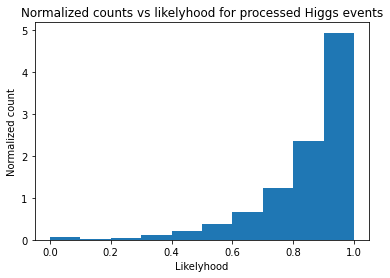

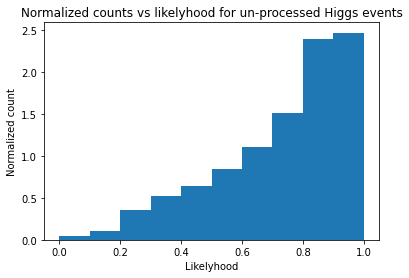

In [37]:
#background events
Higgs_proc_values = []

for i in range(len(gg_proc)):
    Higgs_proc_values.append(prob(gg_proc[i]))
    
for i in range(len(tt_proc)):
    Higgs_proc_values.append(prob(tt_proc[i]))
    
for i in range(len(WW_proc)):
    Higgs_proc_values.append(prob(WW_proc[i]))


plt.clf()
plt.title('Normalized counts vs likelyhood for processed Higgs events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Higgs_proc_values, density = True)
plt.savefig('Higgs_proc_likelyhood')
plt.show()

Higgs_nonproc_values = []

for i in range(len(tt_nonproc)):
    Higgs_nonproc_values.append(prob(tt_nonproc[i]))
    
for i in range(len(WW_nonproc)):
    Higgs_nonproc_values.append(prob(WW_nonproc[i]))
    
for i in range(len(gg_nonproc)):
    Higgs_nonproc_values.append(prob(gg_nonproc[i]))

plt.clf()
plt.title('Normalized counts vs likelyhood for un-processed Higgs events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(Higgs_nonproc_values, density = True)
plt.savefig('Higgs_non_proc_likelyhood')
plt.show()

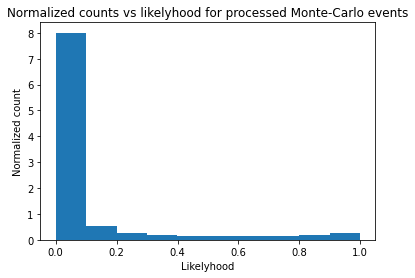

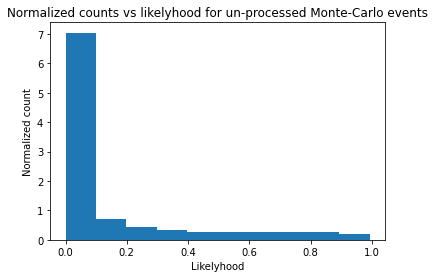

In [38]:
#background events
back_proc_values = []

for i in range(len(back_proc)):
    back_proc_values.append(prob(back_proc[i]))

plt.clf()
plt.title('Normalized counts vs likelyhood for processed Monte-Carlo events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(back_proc_values, density = True)
plt.savefig('proc_likelyhood')
plt.show()

back_nonproc_values = []

for i in range(len(back_nonproc)):
    back_nonproc_values.append(prob(back_nonproc[i]))

plt.clf()
plt.title('Normalized counts vs likelyhood for un-processed Monte-Carlo events')
plt.xlabel('Likelyhood')
plt.ylabel('Normalized count')
plt.hist(back_nonproc_values, density = True)
plt.savefig('non_proc_likelyhood')
plt.show()

In [173]:
ggnonproc_values=[]
for i in range(len(gg_nonproc)):
    ggnonproc_values.append(prob(gg_nonproc[i]))
    
    
ggproc_values=[]
for i in range(len(gg_proc)):
    ggproc_values.append(prob(gg_proc[i]))

In [174]:
ttnonproc_values=[]
for i in range(len(tt_nonproc)):
    ttnonproc_values.append(prob(tt_nonproc[i]))
    
    
ttproc_values=[]
for i in range(len(tt_proc)):
    ttproc_values.append(prob(tt_proc[i]))

In [175]:
WWnonproc_values=[]
for i in range(len(WW_nonproc)):
    WWnonproc_values.append(prob(WW_nonproc[i]))
    
    
WWproc_values=[]
for i in range(len(WW_proc)):
    WWproc_values.append(prob(WW_proc[i]))

In [188]:
def posrate(values, low, high):
    higgs = 0
    background = 0

    for i in range(len(values)):
        if values[i] < low:
            background += 1

        elif values[i] > high:
            higgs += 1

    higgs /= len(values)
    background /= len(values)

    print(higgs)
    print(background)

In [189]:
#background
posrate(back_nonproc_values, 0.25, 0.95)
print('')
posrate(back_proc_values, 0.25, 0.95)

0.0009599952000239999
0.7950060249698752

0.011369943150284249
0.8688056559717201


In [190]:
posrate(ggnonproc_values, 0.05, 0.75)
print('')
posrate(ggproc_values, 0.05, 0.75)

0.3378533107334463
0.001039994800026

0.69359653201734
0.0013249933750331248


In [191]:
posrate(ttnonproc_values, 0.05, 0.75)
print('')
posrate(ttproc_values, 0.05, 0.75)

0.7257113714431428
0.005719971400142999

0.8615156924215379
0.008814955925220374


In [192]:
posrate(WWnonproc_values, 0.05, 0.75)
print('')
posrate(WWproc_values, 0.05, 0.75)

0.6450267748661257
0.004074979625101874

0.842840785796071
0.004699976500117499


In [62]:
def rate(certainty, prediction):#explain
    rates = []
    for i in range(len(certainty)):
        var = 0
        for j in range(len(prediction)):
            if prob(prediction[j]) > certainty[i]:
                var += 1
            
        var /= len(prediction)
        rates.append(var)
    return rates

In [80]:
certainty = [0.05*i for i in range(1,21)]

def compute_eff(certainty, prediction, answer, title):
    
    eff = []
    
    for i in range(len(certainty)):
        print(certainty[i])
        efficiency = 0
        for j in range(len(prediction)):
            if prob(prediction[j]) > certainty[i] and answer[j][-1] == 0:
                efficiency += 1

            if prob(prediction[j]) < certainty[i] and answer[j][-1] == 1:
                efficiency += 1

        efficiency /= len(prediction)
        eff.append(efficiency)
        
    plt.clf()
    plt.plot(certainty, eff)
    plt.title(title)
    plt.xlabel('certainty')
    plt.ylabel('efficiency')
    plt.show()
    
    return eff

0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


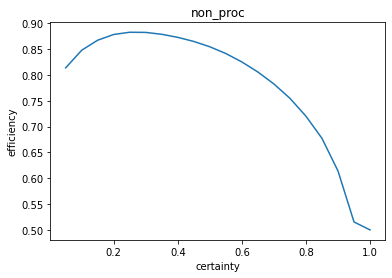

0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


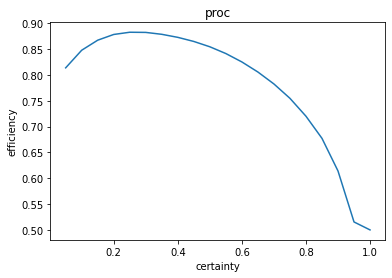

In [193]:
nonproc_eff = compute_eff(certainty, new_nonproc, a_answer, 'non_proc')
proc_eff = compute_eff(certainty, new_nonproc, a_answer, 'proc')

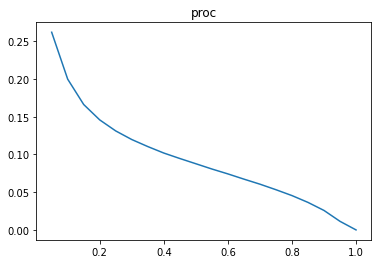

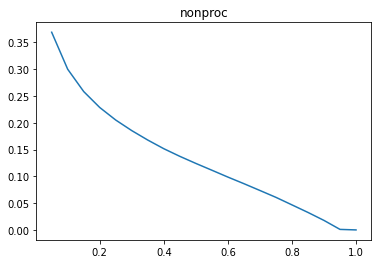

In [196]:
nonproc_rate = rate(certainty, nonproc)
proc_rate = rate(certainty, proc)

plt.clf()
plt.plot(certainty, proc_rate)
plt.title('proc')
plt.show()

plt.clf()
plt.title('nonproc')
plt.plot(certainty, nonproc_rate)
plt.show()

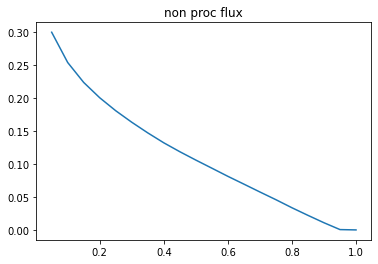

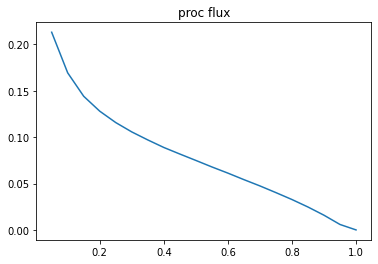

In [86]:
non_proc_flux = [nonproc_rate[i]*nonproc_eff[i] for i in range(len(certainty))]
proc_flux = [proc_rate[i]* proc_eff[i] for i in range(len(certainty))]

plt.clf()
plt.plot(certainty, non_proc_flux)
plt.title('non proc flux')
plt.show()

plt.clf()
plt.plot(certainty, proc_flux)
plt.title('proc flux')
plt.show()

In [87]:
print(non_proc_flux)

[0.30005665742592436, 0.2541386230657492, 0.22383969226414802, 0.20060487661705206, 0.18089346637331394, 0.1634380224156899, 0.14727652018111628, 0.13221307932423476, 0.11870134870021214, 0.1059982804312124, 0.09370602220410199, 0.08133652864518014, 0.06950489323266337, 0.057571163191095474, 0.04585678599766027, 0.03363446365452259, 0.022085542798186548, 0.010874583928888846, 0.0004947766522211084, 0.0]


In [89]:
print(proc_flux)

[0.21317267410126303, 0.16939749460415235, 0.1441180448159489, 0.12805799714182714, 0.11577023010730468, 0.10568603986195922, 0.09705264423363134, 0.08891280503639348, 0.08184332193140127, 0.07493990859904051, 0.06793150341660088, 0.061257101623285674, 0.054228959750713436, 0.04744721331418068, 0.040216182487169724, 0.03277407225845806, 0.024702762571756718, 0.015848278441819373, 0.005860010974743753, 0.0]
